### Import Necessary Packages

In [1]:
import pandas
import numpy as np
import os
import shutil
import torch

### Import Data

In [2]:
# labels = ["coca_cola","fanta","7up"]
# for label in labels:
#     os.makedirs(f'classification/train/{label}')
#     os.makedirs(f'classification/val/{label}')
#     os.makedirs(f'classification/test/{label}')

In [3]:
# cola_train_count = 0
# cola_val_count = 0
# cola_test_count = 0
# fanta_train_count = 0
# fanta_val_count = 0
# fanta_test_count = 0
# seven_up_train_count = 0
# seven_up_val_count = 0
# seven_up_test_count = 0

# sub_dir = ["coca cola can", "coca cola plastic bottle", "fanta can", 
#            "fanta plastic bottle", "7up can", "7up plastic bottle"]
# for d in sub_dir:
#     if d.split()[0] == "coca":
#         for f in os.listdir(f'DATA/data/{d}'):
#             if cola_train_count < 800:
#                 shutil.copy(f'DATA/data/{d}/'+f,f'classification/train/coca_cola/{cola_train_count}.jpg')
#                 cola_train_count += 1
#             elif cola_val_count < 100:
#                 shutil.copy(f'DATA/data/{d}/'+f,f'classification/val/coca_cola/{cola_val_count}.jpg')
#                 cola_val_count += 1
#             elif cola_test_count < 100:
#                 shutil.copy(f'DATA/data/{d}/'+f,f'classification/test/coca_cola/{cola_test_count}.jpg')
#                 cola_test_count += 1
#     elif d.split()[0] == "fanta":
#         for f in os.listdir(f'DATA/data/{d}'):
#             if fanta_train_count < 800:
#                 shutil.copy(f'DATA/data/{d}/'+f,f'classification/train/fanta/{fanta_train_count}.jpg')
#                 fanta_train_count += 1
#             elif fanta_val_count < 100:
#                 shutil.copy(f'DATA/data/{d}/'+f,f'classification/val/fanta/{fanta_val_count}.jpg')
#                 fanta_val_count += 1
#             elif fanta_test_count < 100:
#                 shutil.copy(f'DATA/data/{d}/'+f,f'classification/test/fanta/{fanta_test_count}.jpg')
#                 fanta_test_count += 1
#     elif d.split()[0] == "7up":
#         for f in os.listdir(f'DATA/data/{d}'):
#             if seven_up_train_count < 800:
#                 shutil.copy(f'DATA/data/{d}/'+f,f'classification/train/7up/{seven_up_train_count}.jpg')
#                 seven_up_train_count += 1
#             elif seven_up_val_count < 100:
#                 shutil.copy(f'DATA/data/{d}/'+f,f'classification/val/7up/{seven_up_val_count}.jpg')
#                 seven_up_val_count += 1
#             elif seven_up_test_count < 100:
#                 shutil.copy(f'DATA/data/{d}/'+f,f'classification/test/7up/{seven_up_test_count}.jpg')
#                 seven_up_test_count += 1

In [4]:
train_dir = 'classification/train'
val_dir = 'classification/val'
test_dir = 'classification/test'

### Data Process

In [5]:
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, datasets
from collections import OrderedDict

In [6]:
dataset_transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.RandomRotation(30),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
# Create train, validation and test dataset
train_dataset = datasets.ImageFolder(train_dir,transform=dataset_transform)
val_dataset = datasets.ImageFolder(val_dir,transform=dataset_transform)
test_dataset = datasets.ImageFolder(test_dir,transform=dataset_transform)

In [8]:
# Load datasets into dataloader for iteration
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 100, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 100, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = True)

### Training process

In [9]:
# Training function
def training(model):
    iteration = 0
    minLoss = float("inf")
    best_parameters = None

    # Training Loop
    for epoch in range(epochs):
        # Iterate over the training dataloader
        for i, (images, labels) in enumerate(train_dataloader):
            # Reinitialize the gradient
            optimizer.zero_grad()

            # Get the correct label
            images, labels = images.to(device), labels.to(device)

            # Forward propagation
            outputs = model(images)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Use the loss for back propagation
            loss.backward()

            # Update network parameters
            optimizer.step()
            
            # Empty the cache of GPU
            del images
            del labels
            del loss
            del outputs
            torch.cuda.empty_cache()

            iteration += 1

            if iteration % 10 == 0 or iteration == 1:
                # Calculate Accuracy and loss        
                correct = 0
                total = 0

                total_loss = 0

                # Validation Loop
                # Iterate over the validation dataloader
                for images, labels in val_dataloader:

                    images, labels = images.to(device), labels.to(device)
                    # Make prediction
                    outputs = model(images)

                    loss = criterion(outputs, labels)
                    total_loss += float(loss)

                    # Get predictions from the maximum value, index 0 is the maximum value, 
                    # index 1 is the index of the maximum value
                    _, predicted = torch.max(outputs.data, 1)

                    # Number of labels
                    total += labels.size(0)

                    # Number of correct predictions
                    correct += (predicted == labels).sum()
                    
                    # Empty cache of GPU
                    del images
                    del labels
                    del loss
                    del outputs
                    torch.cuda.empty_cache()

                # Calculate accuracy
                accuracy = 100 * correct / total

                # Save parameters if loss is smaller
                if total_loss < minLoss:
                    minLoss = total_loss
                    best_parameters = model.state_dict()

                # Print accuracy and loss
                print(f'Iteration {iteration}: Loss: {total_loss}, Validation accuracy: {accuracy}')
    return best_parameters

In [10]:
import matplotlib.pyplot as plt
# Testing
def test(model):
    correct = 0
    total = 0
    total_loss = 0
    count = 0

    # Test Loop
    for images, labels in test_dataloader:

        images, labels = images.to(device), labels.to(device)

        # Make prediction
        outputs = model(images)

        loss = criterion(outputs, labels)
        total_loss += float(loss)

        # Get predictions from the maximum value, index 0 is the maximum value, 
        # index 1 is the index of the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Number of labels
        total += labels.size(0)

        # Number of correct predictions
        correct += (predicted == labels).sum()
        
        # Empty cache
        del images
        del labels
        del loss
        del outputs
        torch.cuda.empty_cache()

    # Calculate accuracy
    accuracy = 100 * correct / total

    # Print accuracy and loss
    print(f'Best model has Loss: {total_loss}, Test accuracy: {accuracy}')

### Show prediction mistakes

In [91]:
labels = ['7-up', 'coca_cola', 'fanta']

In [92]:
def show_mistake(model, test_loader, show_count=5):
    count = 0
    for test_x, test_y in test_loader: 
        test_x, test_y = test_x.to(device), test_y.to(device)
        predict = model(test_x)
        # get the index of max predict as label
        _, predict_label = torch.max(predict.data, 1)
        for i in range(len(test_y)):
            if predict_label[i] != test_y[i]:
                count += 1
                if count > show_count:
                    return
                pred = labels[predict_label[i]]
                true_label = labels[test_y[i]]
                print('True Label: ', true_label)
                print('Prediction: ', pred)
#                 img = Image.open(test_x[0])
                img = torch.tensor(test_x[i], device = 'cpu')
#                 img = test_x[i]
                plt.imshow(img.permute(1, 2, 0))
                plt.axis('off')
                plt.show()

### VGG Model

In [13]:
VGG = models.vgg16(pretrained=True)
VGG

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
# Modify the last layer
VGG.classifier[6] = nn.Linear(in_features=4096, out_features=3)
# VGG.classifier.add_module("7", nn.Sigmoid())
# print(VGG.classifier)

In [15]:
# Only unfreeze the last two layer
to_update = ["classifier.6.weight", "classifier.6.bias"]
to_update_params = []
for name, param in VGG.named_parameters():
    if name in to_update:
        param.requires_grad = True
        to_update_params.append(param)
    else:
        param.requires_grad = False

In [16]:
# Training hyperparameters
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=to_update_params, lr=0.01)

In [17]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VGG = VGG.to(device)

In [18]:
# Training
vgg_best_parameters = training(VGG)

C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Iteration 1: Loss: 4.101436495780945, Validation accuracy: 45.0
Iteration 10: Loss: 5.069746494293213, Validation accuracy: 59.66666793823242
Iteration 20: Loss: 4.996329307556152, Validation accuracy: 57.66666793823242
Iteration 30: Loss: 3.6658559441566467, Validation accuracy: 66.33333587646484
Iteration 40: Loss: 3.723602533340454, Validation accuracy: 70.0
Iteration 50: Loss: 3.170885145664215, Validation accuracy: 67.66667175292969
Iteration 60: Loss: 3.302411913871765, Validation accuracy: 70.0
Iteration 70: Loss: 3.7757501006126404, Validation accuracy: 66.66667175292969
Iteration 80: Loss: 4.475154161453247, Validation accuracy: 65.33333587646484
Iteration 90: Loss: 3.821897029876709, Validation accuracy: 67.0
Iteration 100: Loss: 3.011824607849121, Validation accuracy: 72.0
Iteration 110: Loss: 3.425715446472168, Validation accuracy: 71.66667175292969
Iteration 120: Loss: 3.126922845840454, Validation accuracy: 75.66667175292969
Iteration 130: Loss: 3.238684117794037, Validat

In [19]:
import os
ModelPath = 'best_models'
if not os.path.exists(ModelPath):
    os.makedirs(ModelPath)

In [22]:
torch.save(vgg_best_parameters, ModelPath+'/vgg_params.pt')

In [23]:
VGG.load_state_dict(torch.load("./best_models/vgg_params.pt"))

<All keys matched successfully>

In [24]:
test(VGG)

Best model has Loss: 4.031574904918671, Test accuracy: 71.0


### AlexNet Model

In [25]:
alexnet = models.alexnet(pretrained=True)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=3)

In [27]:
# Only unfreeze the last two layer
to_update = ["classifier.6.weight", "classifier.6.bias"]
to_update_params = []
for name, param in alexnet.named_parameters():
    if name in to_update:
        param.requires_grad = True
        to_update_params.append(param)
    else:
        param.requires_grad = False

In [28]:
# Training hyperparameters
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=to_update_params, lr=0.01)

In [29]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

In [30]:
# Training
alexnet_best_parameters = training(alexnet)

Iteration 1: Loss: 21.127562046051025, Validation accuracy: 51.333335876464844
Iteration 10: Loss: 7.245911359786987, Validation accuracy: 74.0
Iteration 20: Loss: 6.610734701156616, Validation accuracy: 77.0
Iteration 30: Loss: 3.600994348526001, Validation accuracy: 81.66667175292969
Iteration 40: Loss: 3.4707544445991516, Validation accuracy: 81.33333587646484
Iteration 50: Loss: 2.772453546524048, Validation accuracy: 83.66667175292969
Iteration 60: Loss: 2.2210060954093933, Validation accuracy: 85.0
Iteration 70: Loss: 2.602265417575836, Validation accuracy: 87.0
Iteration 80: Loss: 2.452853500843048, Validation accuracy: 89.66667175292969
Iteration 90: Loss: 2.5943344235420227, Validation accuracy: 86.66667175292969
Iteration 100: Loss: 2.0678849816322327, Validation accuracy: 88.33333587646484
Iteration 110: Loss: 2.5683685541152954, Validation accuracy: 87.0
Iteration 120: Loss: 1.6003236770629883, Validation accuracy: 89.33333587646484
Iteration 130: Loss: 2.3323658108711243, 

In [31]:
# save the model params
torch.save(alexnet_best_parameters, ModelPath+'/alexnet_params.pt')

In [32]:
alexnet.load_state_dict(torch.load("./best_models/alexnet_params.pt"))

<All keys matched successfully>

In [33]:
test(alexnet)

Best model has Loss: 1.2376136630773544, Test accuracy: 92.0


### GoogleNet

In [34]:
googlenet = models.googlenet(pretrained=True)
googlenet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [35]:
googlenet.fc = nn.Linear(in_features=1024, out_features=3, bias=True)

In [36]:
# Only unfreeze the last two layer
to_update = ["fc.weight", "fc.bias"]
to_update_params = []
for name, param in googlenet.named_parameters():
    if name in to_update:
        param.requires_grad = True
        to_update_params.append(param)
    else:
        param.requires_grad = False

In [37]:
# Training hyperparameters
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=to_update_params, lr=0.01)

In [38]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
googlenet = googlenet.to(device)

In [39]:
# Training
googlenet_best_parameters = training(googlenet)

Iteration 1: Loss: 4.7934653759002686, Validation accuracy: 34.0
Iteration 10: Loss: 2.4684740900993347, Validation accuracy: 64.33333587646484
Iteration 20: Loss: 2.1986535787582397, Validation accuracy: 70.33333587646484
Iteration 30: Loss: 1.869311273097992, Validation accuracy: 73.33333587646484
Iteration 40: Loss: 2.0260276198387146, Validation accuracy: 73.33333587646484
Iteration 50: Loss: 1.6848293840885162, Validation accuracy: 79.66667175292969
Iteration 60: Loss: 1.6384647488594055, Validation accuracy: 80.33333587646484
Iteration 70: Loss: 1.7574639320373535, Validation accuracy: 76.66667175292969
Iteration 80: Loss: 1.6746962368488312, Validation accuracy: 77.33333587646484
Iteration 90: Loss: 1.892849087715149, Validation accuracy: 75.33333587646484
Iteration 100: Loss: 1.671174705028534, Validation accuracy: 77.66667175292969
Iteration 110: Loss: 1.6087691485881805, Validation accuracy: 80.0
Iteration 120: Loss: 1.8872095942497253, Validation accuracy: 73.66667175292969


In [40]:
# save the model params
torch.save(googlenet_best_parameters, ModelPath+'/googlenet_params.pt')

In [41]:
googlenet.load_state_dict(torch.load("./best_models/googlenet_params.pt"))

<All keys matched successfully>

In [42]:
test(googlenet)

Best model has Loss: 1.210945576429367, Test accuracy: 83.33333587646484


### ResNet

In [43]:
resnet18 = models.resnet18(pretrained=True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
resnet18.fc = nn.Linear(in_features=512, out_features=3, bias=True)

In [45]:
# Only unfreeze the last two layer
to_update = ["fc.weight", "fc.bias"]
to_update_params = []
for name, param in resnet18.named_parameters():
    if name in to_update:
        param.requires_grad = True
        to_update_params.append(param)
    else:
        param.requires_grad = False

In [46]:
# Training hyperparameters
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=to_update_params, lr=0.01)

In [47]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

In [48]:
# Training
resnet18_best_parameters = training(resnet18)

Iteration 1: Loss: 9.593112468719482, Validation accuracy: 40.66666793823242
Iteration 10: Loss: 2.585853934288025, Validation accuracy: 60.0
Iteration 20: Loss: 2.2401528358459473, Validation accuracy: 66.66667175292969
Iteration 30: Loss: 1.815514624118805, Validation accuracy: 76.0
Iteration 40: Loss: 1.6901259422302246, Validation accuracy: 81.66667175292969
Iteration 50: Loss: 1.6211684942245483, Validation accuracy: 77.66667175292969
Iteration 60: Loss: 1.575486421585083, Validation accuracy: 82.0
Iteration 70: Loss: 1.4746342897415161, Validation accuracy: 82.0
Iteration 80: Loss: 1.4134852588176727, Validation accuracy: 85.0
Iteration 90: Loss: 1.4097643494606018, Validation accuracy: 83.33333587646484
Iteration 100: Loss: 1.3140751719474792, Validation accuracy: 85.0
Iteration 110: Loss: 1.3476934731006622, Validation accuracy: 85.0
Iteration 120: Loss: 1.3069131672382355, Validation accuracy: 84.33333587646484
Iteration 130: Loss: 1.5490384697914124, Validation accuracy: 80.6

In [49]:
# save the model params
torch.save(resnet18_best_parameters, ModelPath+'/resnet18_params.pt')

In [50]:
resnet18.load_state_dict(torch.load("./best_models/resnet18_params.pt"))

<All keys matched successfully>

In [51]:
test(resnet18)

Best model has Loss: 1.2038506418466568, Test accuracy: 85.33333587646484


### MobileNet V3 Small

In [52]:
mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
mobilenet_v3_small

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

In [53]:
mobilenet_v3_small.classifier[3] = nn.Linear(in_features=1024, out_features=3, bias=True)

In [54]:
# Only unfreeze the last two layer
to_update = ["classifier.3.weight", "classifier.3.bias"]
to_update_params = []
for name, param in mobilenet_v3_small.named_parameters():
    if name in to_update:
        param.requires_grad = True
        to_update_params.append(param)
    else:
        param.requires_grad = False

In [55]:
# Training hyperparameters
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=to_update_params, lr=0.01)

In [56]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v3_small = mobilenet_v3_small.to(device)

In [57]:
# Training
mobilenet_v3_small_best_parameters = training(mobilenet_v3_small)

Iteration 1: Loss: 2.714532256126404, Validation accuracy: 61.0
Iteration 10: Loss: 1.6669201254844666, Validation accuracy: 78.33333587646484
Iteration 20: Loss: 1.2265560328960419, Validation accuracy: 85.0
Iteration 30: Loss: 1.2322867214679718, Validation accuracy: 87.0
Iteration 40: Loss: 1.1176963150501251, Validation accuracy: 86.0
Iteration 50: Loss: 1.1767885982990265, Validation accuracy: 87.66667175292969
Iteration 60: Loss: 1.1330033838748932, Validation accuracy: 87.66667175292969
Iteration 70: Loss: 1.1118780374526978, Validation accuracy: 90.0
Iteration 80: Loss: 0.9890712797641754, Validation accuracy: 89.33333587646484
Iteration 90: Loss: 1.0372865498065948, Validation accuracy: 88.0
Iteration 100: Loss: 0.8612953275442123, Validation accuracy: 90.0
Iteration 110: Loss: 0.9240044057369232, Validation accuracy: 89.33333587646484
Iteration 120: Loss: 0.9091033637523651, Validation accuracy: 89.33333587646484
Iteration 130: Loss: 1.0803271532058716, Validation accuracy: 9

In [58]:
# save the model params
torch.save(mobilenet_v3_small_best_parameters, ModelPath+'/mobilenet_v3_small_params.pt')

In [59]:
mobilenet_v3_small.load_state_dict(torch.load("./best_models/mobilenet_v3_small_params.pt"))

<All keys matched successfully>

In [60]:
test(mobilenet_v3_small)

Best model has Loss: 0.7485496699810028, Test accuracy: 92.66667175292969


### RegNet 16

In [61]:
regnet_x_16gf = models.regnet_x_16gf(pretrained=True)
regnet_x_16gf

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): ConvNormActivation(
          (0): Conv2d(32, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): ConvNormActivation(
            (0): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): ConvNormActivation(
            (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
            

In [62]:
regnet_x_16gf.fc = nn.Linear(in_features=2048, out_features=3, bias=True)

In [63]:
# Only unfreeze the last two layer
to_update = ["fc.weight", "fc.bias"]
to_update_params = []
for name, param in regnet_x_16gf.named_parameters():
    if name in to_update:
        param.requires_grad = True
        to_update_params.append(param)
    else:
        param.requires_grad = False

In [64]:
# Training hyperparameters
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=to_update_params, lr=0.01)

In [65]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regnet_x_16gf = regnet_x_16gf.to(device)

In [66]:
# Training
regnet_x_16gf_best_parameters = training(regnet_x_16gf)

Iteration 1: Loss: 19.77261209487915, Validation accuracy: 33.333335876464844
Iteration 10: Loss: 5.110540866851807, Validation accuracy: 47.66666793823242
Iteration 20: Loss: 2.906424582004547, Validation accuracy: 67.33333587646484
Iteration 30: Loss: 1.6984111964702606, Validation accuracy: 80.33333587646484
Iteration 40: Loss: 1.3667291104793549, Validation accuracy: 82.66667175292969
Iteration 50: Loss: 1.6640446186065674, Validation accuracy: 78.66667175292969
Iteration 60: Loss: 1.3974389433860779, Validation accuracy: 85.0
Iteration 70: Loss: 1.4077592194080353, Validation accuracy: 83.33333587646484
Iteration 80: Loss: 1.3046207427978516, Validation accuracy: 86.66667175292969
Iteration 90: Loss: 1.2065622508525848, Validation accuracy: 86.66667175292969
Iteration 100: Loss: 1.0345174074172974, Validation accuracy: 88.0
Iteration 110: Loss: 2.2285435795783997, Validation accuracy: 76.66667175292969
Iteration 120: Loss: 1.1671926975250244, Validation accuracy: 86.66667175292969

In [67]:
# save the model params
torch.save(regnet_x_16gf_best_parameters, ModelPath+'/regnet_x_16gf_params.pt')

In [68]:
regnet_x_16gf.load_state_dict(torch.load("./best_models/regnet_x_16gf_params.pt"))

<All keys matched successfully>

In [69]:
test(regnet_x_16gf)

Best model has Loss: 0.7528079301118851, Test accuracy: 91.0


### Expriment on customized CNN model

In [70]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Fully connected output
        self.linear_layers = nn.Sequential(
            nn.Linear(100352, 3)
        )
 
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [71]:
CNNmodel = CNNModel()

In [72]:
CNNmodel

CNNModel(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=100352, out_features=3, bias=True)
  )
)

In [73]:
to_update_params = []
for name, param in CNNmodel.named_parameters():
    to_update_params.append(param)

In [74]:
# Training hyperparameters
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=to_update_params, lr=0.01)

In [75]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNNmodel = CNNmodel.to(device)

In [76]:
# Training
CNN_best_parameters = training(CNNmodel)

Iteration 1: Loss: 1427.2468872070312, Validation accuracy: 33.333335876464844
Iteration 10: Loss: 366.48474884033203, Validation accuracy: 43.66666793823242
Iteration 20: Loss: 105.47512817382812, Validation accuracy: 54.333335876464844
Iteration 30: Loss: 58.70601558685303, Validation accuracy: 64.33333587646484
Iteration 40: Loss: 68.26784896850586, Validation accuracy: 58.66666793823242
Iteration 50: Loss: 33.195255279541016, Validation accuracy: 67.0
Iteration 60: Loss: 32.30305004119873, Validation accuracy: 65.33333587646484
Iteration 70: Loss: 29.449877738952637, Validation accuracy: 62.0
Iteration 80: Loss: 43.55285930633545, Validation accuracy: 63.0
Iteration 90: Loss: 27.645156860351562, Validation accuracy: 73.0
Iteration 100: Loss: 19.801355838775635, Validation accuracy: 72.0
Iteration 110: Loss: 9.710042715072632, Validation accuracy: 78.0
Iteration 120: Loss: 8.69559931755066, Validation accuracy: 79.66667175292969
Iteration 130: Loss: 11.908606767654419, Validation ac

In [77]:
# save the model params
torch.save(CNN_best_parameters, ModelPath+'/CNN_params.pt')

In [78]:
CNNmodel.load_state_dict(torch.load("./best_models/CNN_params.pt"))

<All keys matched successfully>

In [79]:
test(CNNmodel)

Best model has Loss: 3.582597315311432, Test accuracy: 82.66667175292969


In [80]:
class CNNModel2(nn.Module):
    def __init__(self):
        super(CNNModel2, self).__init__()
        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        # Fully connected output
        self.linear_layers = nn.Sequential(
            nn.Linear(100352, 3)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [81]:
CNNmodel2 = CNNModel2()

In [82]:
CNNmodel2

CNNModel2(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=100352, out_features=3, bias=True)
  )
)

In [83]:
to_update_params = []
for name, param in CNNmodel2.named_parameters():
    to_update_params.append(param)

In [84]:
# Training hyperparameters
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=to_update_params, lr=0.01)

In [85]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNNmodel2 = CNNmodel2.to(device)

In [86]:
# Training
CNN2_best_parameters = training(CNNmodel2)

Iteration 1: Loss: 1407.0654602050781, Validation accuracy: 33.333335876464844
Iteration 10: Loss: 282.59368896484375, Validation accuracy: 42.333335876464844
Iteration 20: Loss: 139.9194679260254, Validation accuracy: 56.333335876464844
Iteration 30: Loss: 68.13080215454102, Validation accuracy: 62.66666793823242
Iteration 40: Loss: 36.69658851623535, Validation accuracy: 67.66667175292969
Iteration 50: Loss: 27.209123611450195, Validation accuracy: 65.66667175292969
Iteration 60: Loss: 42.89238739013672, Validation accuracy: 63.0
Iteration 70: Loss: 54.83158874511719, Validation accuracy: 64.33333587646484
Iteration 80: Loss: 42.196242332458496, Validation accuracy: 72.0
Iteration 90: Loss: 46.21877479553223, Validation accuracy: 67.66667175292969
Iteration 100: Loss: 29.647456645965576, Validation accuracy: 68.33333587646484
Iteration 110: Loss: 27.55362892150879, Validation accuracy: 66.66667175292969
Iteration 120: Loss: 21.502939224243164, Validation accuracy: 69.33333587646484
I

In [87]:
# save the model params
torch.save(CNN2_best_parameters, ModelPath+'/CNN2_params.pt')

In [88]:
CNNmodel2.load_state_dict(torch.load("./best_models/CNN2_params.pt"))

<All keys matched successfully>

In [89]:
test(CNNmodel2)

Best model has Loss: 3.234672427177429, Test accuracy: 82.0


C:\Users\Leo\AppData\Local\Temp/ipykernel_8412/500350670.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(test_x[i], device = 'cpu')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label:  coca_cola
Prediction:  7-up


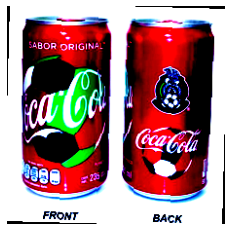

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label:  coca_cola
Prediction:  7-up


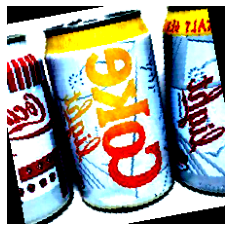

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label:  coca_cola
Prediction:  7-up


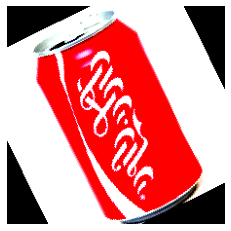

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label:  7-up
Prediction:  coca_cola


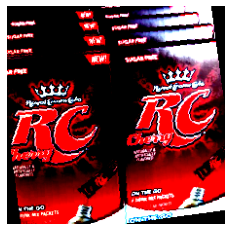

True Label:  coca_cola
Prediction:  7-up


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


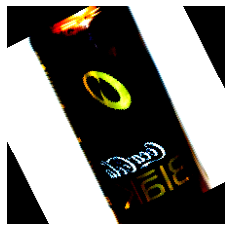

In [93]:
show_mistake(VGG, test_dataloader)

C:\Users\Leo\AppData\Local\Temp/ipykernel_8412/500350670.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(test_x[i], device = 'cpu')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label:  7-up
Prediction:  coca_cola


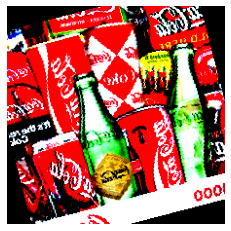

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label:  7-up
Prediction:  coca_cola


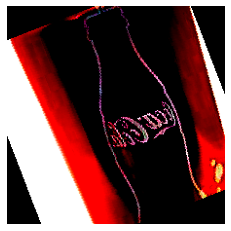

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label:  fanta
Prediction:  7-up


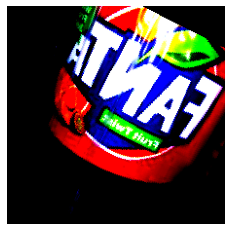

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label:  7-up
Prediction:  coca_cola


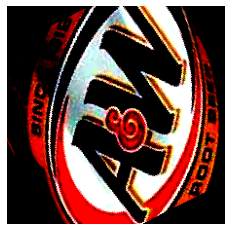

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label:  7-up
Prediction:  coca_cola


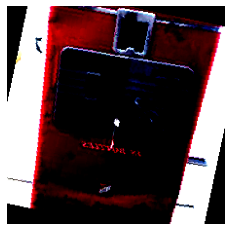

In [94]:
show_mistake(alexnet, test_dataloader)

In [95]:
from torchensemble import VotingClassifier 

In [96]:
ensemble = VotingClassifier(estimator=mobilenet_v3_small, n_estimators=10)
criterion = nn.CrossEntropyLoss()
ensemble.set_criterion(criterion)
ensemble.set_optimizer("Adam", lr=0.01)

In [97]:
ensemble.set_scheduler("CosineAnnealingLR", T_max=10)

In [98]:
ensemble.fit(train_dataloader, epochs=10)

C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 000 | Epoch: 000 | Batch: 000 | Loss: 0.11338 | Correct: 95/100
Estimator: 001 | Epoch: 000 | Batch: 000 | Loss: 0.11483 | Correct: 96/100
Estimator: 002 | Epoch: 000 | Batch: 000 | Loss: 0.15296 | Correct: 94/100
Estimator: 003 | Epoch: 000 | Batch: 000 | Loss: 0.21876 | Correct: 93/100
Estimator: 004 | Epoch: 000 | Batch: 000 | Loss: 0.13264 | Correct: 96/100
Estimator: 005 | Epoch: 000 | Batch: 000 | Loss: 0.25605 | Correct: 89/100
Estimator: 006 | Epoch: 000 | Batch: 000 | Loss: 0.16253 | Correct: 95/100
Estimator: 007 | Epoch: 000 | Batch: 000 | Loss: 0.19375 | Correct: 92/100
Estimator: 008 | Epoch: 000 | Batch: 000 | Loss: 0.22158 | Correct: 91/100
Estimator: 009 | Epoch: 000 | Batch: 000 | Loss: 0.14749 | Correct: 94/100
Estimator: 000 | Epoch: 001 | Batch: 000 | Loss: 0.20043 | Correct: 94/100


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 001 | Epoch: 001 | Batch: 000 | Loss: 0.27760 | Correct: 91/100
Estimator: 002 | Epoch: 001 | Batch: 000 | Loss: 0.13521 | Correct: 95/100
Estimator: 003 | Epoch: 001 | Batch: 000 | Loss: 0.17931 | Correct: 94/100
Estimator: 004 | Epoch: 001 | Batch: 000 | Loss: 0.07035 | Correct: 98/100
Estimator: 005 | Epoch: 001 | Batch: 000 | Loss: 0.10165 | Correct: 95/100
Estimator: 006 | Epoch: 001 | Batch: 000 | Loss: 0.25825 | Correct: 90/100
Estimator: 007 | Epoch: 001 | Batch: 000 | Loss: 0.13159 | Correct: 95/100
Estimator: 008 | Epoch: 001 | Batch: 000 | Loss: 0.20344 | Correct: 92/100
Estimator: 009 | Epoch: 001 | Batch: 000 | Loss: 0.27416 | Correct: 93/100
Estimator: 000 | Epoch: 002 | Batch: 000 | Loss: 0.07463 | Correct: 97/100


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 001 | Epoch: 002 | Batch: 000 | Loss: 0.23847 | Correct: 92/100
Estimator: 002 | Epoch: 002 | Batch: 000 | Loss: 0.13862 | Correct: 95/100
Estimator: 003 | Epoch: 002 | Batch: 000 | Loss: 0.21038 | Correct: 89/100
Estimator: 004 | Epoch: 002 | Batch: 000 | Loss: 0.11334 | Correct: 97/100
Estimator: 005 | Epoch: 002 | Batch: 000 | Loss: 0.09870 | Correct: 95/100
Estimator: 006 | Epoch: 002 | Batch: 000 | Loss: 0.19963 | Correct: 94/100
Estimator: 007 | Epoch: 002 | Batch: 000 | Loss: 0.13130 | Correct: 97/100
Estimator: 008 | Epoch: 002 | Batch: 000 | Loss: 0.23521 | Correct: 95/100
Estimator: 009 | Epoch: 002 | Batch: 000 | Loss: 0.16373 | Correct: 93/100
Estimator: 000 | Epoch: 003 | Batch: 000 | Loss: 0.33152 | Correct: 92/100


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 001 | Epoch: 003 | Batch: 000 | Loss: 0.12576 | Correct: 94/100
Estimator: 002 | Epoch: 003 | Batch: 000 | Loss: 0.07699 | Correct: 98/100
Estimator: 003 | Epoch: 003 | Batch: 000 | Loss: 0.16830 | Correct: 97/100
Estimator: 004 | Epoch: 003 | Batch: 000 | Loss: 0.18754 | Correct: 93/100
Estimator: 005 | Epoch: 003 | Batch: 000 | Loss: 0.23883 | Correct: 95/100
Estimator: 006 | Epoch: 003 | Batch: 000 | Loss: 0.36313 | Correct: 91/100
Estimator: 007 | Epoch: 003 | Batch: 000 | Loss: 0.09825 | Correct: 96/100
Estimator: 008 | Epoch: 003 | Batch: 000 | Loss: 0.15375 | Correct: 93/100
Estimator: 009 | Epoch: 003 | Batch: 000 | Loss: 0.12727 | Correct: 96/100
Estimator: 000 | Epoch: 004 | Batch: 000 | Loss: 0.12779 | Correct: 96/100


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 001 | Epoch: 004 | Batch: 000 | Loss: 0.10804 | Correct: 95/100
Estimator: 002 | Epoch: 004 | Batch: 000 | Loss: 0.15929 | Correct: 94/100
Estimator: 003 | Epoch: 004 | Batch: 000 | Loss: 0.18527 | Correct: 94/100
Estimator: 004 | Epoch: 004 | Batch: 000 | Loss: 0.20448 | Correct: 91/100
Estimator: 005 | Epoch: 004 | Batch: 000 | Loss: 0.15922 | Correct: 93/100
Estimator: 006 | Epoch: 004 | Batch: 000 | Loss: 0.12314 | Correct: 95/100
Estimator: 007 | Epoch: 004 | Batch: 000 | Loss: 0.12991 | Correct: 96/100
Estimator: 008 | Epoch: 004 | Batch: 000 | Loss: 0.12485 | Correct: 95/100
Estimator: 009 | Epoch: 004 | Batch: 000 | Loss: 0.09596 | Correct: 96/100
Estimator: 000 | Epoch: 005 | Batch: 000 | Loss: 0.24273 | Correct: 91/100


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 001 | Epoch: 005 | Batch: 000 | Loss: 0.19393 | Correct: 92/100
Estimator: 002 | Epoch: 005 | Batch: 000 | Loss: 0.07093 | Correct: 98/100
Estimator: 003 | Epoch: 005 | Batch: 000 | Loss: 0.20435 | Correct: 96/100
Estimator: 004 | Epoch: 005 | Batch: 000 | Loss: 0.10941 | Correct: 95/100
Estimator: 005 | Epoch: 005 | Batch: 000 | Loss: 0.26736 | Correct: 94/100
Estimator: 006 | Epoch: 005 | Batch: 000 | Loss: 0.21614 | Correct: 90/100
Estimator: 007 | Epoch: 005 | Batch: 000 | Loss: 0.11689 | Correct: 95/100
Estimator: 008 | Epoch: 005 | Batch: 000 | Loss: 0.12496 | Correct: 96/100
Estimator: 009 | Epoch: 005 | Batch: 000 | Loss: 0.14464 | Correct: 97/100


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 000 | Epoch: 006 | Batch: 000 | Loss: 0.08933 | Correct: 96/100
Estimator: 001 | Epoch: 006 | Batch: 000 | Loss: 0.12384 | Correct: 94/100
Estimator: 002 | Epoch: 006 | Batch: 000 | Loss: 0.21038 | Correct: 93/100
Estimator: 003 | Epoch: 006 | Batch: 000 | Loss: 0.11762 | Correct: 96/100
Estimator: 004 | Epoch: 006 | Batch: 000 | Loss: 0.11017 | Correct: 95/100
Estimator: 005 | Epoch: 006 | Batch: 000 | Loss: 0.14591 | Correct: 95/100
Estimator: 006 | Epoch: 006 | Batch: 000 | Loss: 0.06604 | Correct: 99/100
Estimator: 007 | Epoch: 006 | Batch: 000 | Loss: 0.14495 | Correct: 95/100
Estimator: 008 | Epoch: 006 | Batch: 000 | Loss: 0.11414 | Correct: 97/100
Estimator: 009 | Epoch: 006 | Batch: 000 | Loss: 0.11771 | Correct: 96/100
Estimator: 000 | Epoch: 007 | Batch: 000 | Loss: 0.10742 | Correct: 96/100


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 001 | Epoch: 007 | Batch: 000 | Loss: 0.13804 | Correct: 95/100
Estimator: 002 | Epoch: 007 | Batch: 000 | Loss: 0.23050 | Correct: 93/100
Estimator: 003 | Epoch: 007 | Batch: 000 | Loss: 0.11939 | Correct: 93/100
Estimator: 004 | Epoch: 007 | Batch: 000 | Loss: 0.05236 | Correct: 99/100
Estimator: 005 | Epoch: 007 | Batch: 000 | Loss: 0.14870 | Correct: 94/100
Estimator: 006 | Epoch: 007 | Batch: 000 | Loss: 0.22152 | Correct: 92/100
Estimator: 007 | Epoch: 007 | Batch: 000 | Loss: 0.10713 | Correct: 96/100
Estimator: 008 | Epoch: 007 | Batch: 000 | Loss: 0.11631 | Correct: 95/100
Estimator: 009 | Epoch: 007 | Batch: 000 | Loss: 0.24054 | Correct: 94/100
Estimator: 000 | Epoch: 008 | Batch: 000 | Loss: 0.19047 | Correct: 93/100


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 001 | Epoch: 008 | Batch: 000 | Loss: 0.13187 | Correct: 95/100
Estimator: 002 | Epoch: 008 | Batch: 000 | Loss: 0.14523 | Correct: 94/100
Estimator: 003 | Epoch: 008 | Batch: 000 | Loss: 0.25214 | Correct: 91/100
Estimator: 004 | Epoch: 008 | Batch: 000 | Loss: 0.07633 | Correct: 96/100
Estimator: 005 | Epoch: 008 | Batch: 000 | Loss: 0.10966 | Correct: 97/100
Estimator: 006 | Epoch: 008 | Batch: 000 | Loss: 0.11911 | Correct: 96/100
Estimator: 007 | Epoch: 008 | Batch: 000 | Loss: 0.21910 | Correct: 94/100
Estimator: 008 | Epoch: 008 | Batch: 000 | Loss: 0.07667 | Correct: 97/100
Estimator: 009 | Epoch: 008 | Batch: 000 | Loss: 0.08809 | Correct: 97/100
Estimator: 000 | Epoch: 009 | Batch: 000 | Loss: 0.13501 | Correct: 93/100


C:\Users\Leo\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Estimator: 001 | Epoch: 009 | Batch: 000 | Loss: 0.10338 | Correct: 96/100
Estimator: 002 | Epoch: 009 | Batch: 000 | Loss: 0.23311 | Correct: 93/100
Estimator: 003 | Epoch: 009 | Batch: 000 | Loss: 0.10502 | Correct: 97/100
Estimator: 004 | Epoch: 009 | Batch: 000 | Loss: 0.19692 | Correct: 95/100
Estimator: 005 | Epoch: 009 | Batch: 000 | Loss: 0.09628 | Correct: 97/100
Estimator: 006 | Epoch: 009 | Batch: 000 | Loss: 0.26147 | Correct: 86/100
Estimator: 007 | Epoch: 009 | Batch: 000 | Loss: 0.15786 | Correct: 93/100
Estimator: 008 | Epoch: 009 | Batch: 000 | Loss: 0.09667 | Correct: 95/100
Estimator: 009 | Epoch: 009 | Batch: 000 | Loss: 0.17337 | Correct: 94/100


In [100]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = True)

In [103]:
ensemble.predict(test_dataloader)

ValueError: The type of input X should be one of {{torch.Tensor, np.ndarray}}.